# Quick check of agro datasets exploitability for LeWagon MLProject

- availability of features data: parcels, type of soils, type of crop, weather, sequencial etc
- availability of target data: production (yearly)
- quality of data: nan, length of time series

**TODO**

- list datasets
- links between datasets
- size of datasets
- other datasets?
- objectives

## Objectives

- predict annual crop production per year and per region/parcel
- compare predicted annual production to annual crop consumption per region/parcel
- forecast under production and over production
- infer transport requirement for satisfying demand
- update crop production forecast with weather data
- update crop production with satellite images
- importations vs exportations

## Possible extensions

- get market data, market forecast to compute expectable value

<https://agreste.agriculture.gouv.fr/agreste-web/>

In [1]:
# ML libs
import pandas as pd
import numpy as np

# File manipulation
import os
from urllib.request import urlopen
import json
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET

# Graphic
import matplotlib.pyplot as plt
import plotly.express as px

# Environment variables
datasets_dir = os.environ.get('DATA_DIR_LOCAL')

In [2]:
datasets_dir

# Production per culture per department/region data

In [ ]:
file_name = "cd2023-19_ResultatsDéfinifs-FranceEntiere2021-2022_maj22nov2023.xlsx"
file_path = os.path.join(datasets_dir,file_name)
data = pd.read_excel(file_path, sheet_name=None)

In [ ]:
def format_ssa_sommaire_df(ssa_excel_dict):
    ssa_excel_dict['Sommaire']  = ssa_excel_dict['Sommaire'].dropna(how="all").dropna(axis=1)
    ssa_excel_dict['Sommaire'].rename(columns=dict(zip(ssa_excel_dict['Sommaire'].columns, ['Tableaux', 'Onglets'])), inplace=True)
    ssa_excel_dict['Sommaire']['Onglets'] = ssa_excel_dict['Sommaire']['Onglets'].str.strip('#')
    ssa_excel_dict['Sommaire'].drop(2, inplace=True)
    ssa_excel_dict['Sommaire'].set_index("Tableaux", inplace=True)

In [ ]:
ssa2023_dict = data.copy()
format_ssa_sommaire_df(ssa2023_dict)

In [ ]:
COP = ssa2023_dict[ssa2023_dict['Sommaire'].iloc[0]['Onglets']]
COP

In [ ]:
len(COP)

In [ ]:
file_name = "SAA_2010-2023_provisoires_donnees_regionales.xlsx"
file_path = os.path.join(datasets_dir, file_name)
SAA_regionales = pd.read_excel(file_path, sheet_name=None)

In [ ]:
SAA_regionales['COP']

In [ ]:
file_name = "SAA_2010-2023_provisoires_donnees_departementales.xlsx"
file_path = os.path.join(datasets_dir, file_name)
SAA_departementales = pd.read_excel(file_path, sheet_name=None)

In [ ]:
SAA_departementales.keys()

In [ ]:
SAA_departementales['COP'].drop([0,1,2,3]).describe()

# RPG (Registre Parcellaire Graphique)

In [ ]:
dir_name = "RPG/Projet_carto_RPG_2"
dir_path = os.path.join(datasets_dir, dir_name)
files_list = os.listdir(dir_path)
files_list

In [ ]:
xml_file = os.path.join(dir_path, "Projet_carto_RPG_2-1_FXX.qgs")

with open(xml_file) as fp:
    soup = BeautifulSoup(fp,'lxml')

In [ ]:
soup.find_all('field')

## Pays basque sample dataset of RPG in json format

In [ ]:
json_name = "RPG/rpg-2020-registre-parcellaire-graphique.json"
json_path = os.path.join(datasets_dir, json_name)

with open(json_path, "r") as file:
    js = json.load(file)

In [ ]:
js_small = js[:2000]

In [ ]:
fig, ax = plt.subplots(figsize=(14,14))
#plt.xlim(-5.15,9.57)
#plt.ylim(41.32,51.10)
errors={}
for i, parcel in enumerate(js_small):
    try:
        polygons = parcel['geo_shape']['geometry']['coordinates']
        #print(f"index = {i}")
        for polygon in polygons:
            ax.fill(np.array(polygon)[:,0], np.array(polygon)[:,1], label=parcel['code_cultu'])
    except TypeError as e:
        errors[i]=e
print(errors)
    #ax.plot(np.array(polygon)[:,:,0][0], np.array(polygon)[:,:,1][0], linewidth=3, color="w")

In [ ]:
polygon = js_small[0]['geo_shape']['geometry']['coordinates'][0]
plt.fill(np.array(polygon)[:,0], np.array(polygon)[:,1])
#plt.plot(np.array(polygon)[:,:,0][0], np.array(polygon)[:,:,1][0], linewidth=3, color="w")

## Plotly choropleth maps with json data 

&#x26A0; High risk of machine overload when number of polygons is higher than 1000! 

I lost a notebook this way (was not able to reopen it nor to nbconvert --empty outputs...)

### Preparing data for choropleth maps 

In [ ]:
geo_df = pd.DataFrame(js_small)
geo_df.head(2)

In [ ]:
geo_df['pole_terri'].value_counts()

In [ ]:
def add_id_to_feature(feature, anonid):
    feature['id']=anonid
    return feature

In [ ]:
geo_df['new_geo_shape'] = geo_df.apply(lambda row: add_id_to_feature(row['geo_shape'],row['anon_id']), axis=1)

In [ ]:
small_geo_df = geo_df[geo_df['pole_terri']=="Pays de Bidache"]

Create dictionnary with features collection, this format is mandatory

In [ ]:
geo_dict={'type': 'FeatureCollection',
          'features': small_geo_df['new_geo_shape'].to_list()}

locations must correspond to feature['id']

In [ ]:
fig = px.choropleth_mapbox(small_geo_df, geojson=geo_dict, locations='anon_id', color='code_cultu',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           mapbox_style="carto-positron",
                           zoom=10, center = {"lon": -1.0722637006190943, 'lat': 43.20029146325354},
                           opacity=0.5,
                           labels={'code_cultu':'type de culture'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Example
<details><summary>
dictionary example
</summary>

```
{'type': 'FeatureCollection',
 'features': [{
    'type': 'Feature',
    'properties': {'GEO_ID': '0500000US01001',
        'STATE': '01',
        'COUNTY': '001',
        'NAME': 'Autauga',
        'LSAD': 'County',
        'CENSUSAREA': 594.436},
    'geometry': {
        'type': 'Polygon',
        'coordinates': [[[-86.496774, 32.344437],
         ...,
          [-86.496774, 32.344437]]]},
    'id': '01001'},
  {'type': 'Feature',
   'properties': {'GEO_ID': '0500000US01009',
        ...,
        'CENSUSAREA': 644.776},
   'geometry': {'type': 'Polygon',
        'coordinates': [[[-86.577799, 33.765316],
          ...,
          [-86.577799, 33.765316]]]},
   'id': '01009'},
    ...
}
```
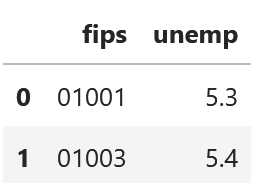{width=5, heigth=5}
</details>

In [ ]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})
fig = px.choropleth_mapbox(df, geojson=counties, locations='fips', color='unemp',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
counties
